This notebook aims to compare different experimental setups and how they affect the spectral retrieval of a gamma-ray spectrum.

The different scenarios are:
- old RAL stack alone with steel plate - setup RR2015 (Cole)
- old RAL stack with steel plate and CsI profile stack (Jena/DESY) - most of BW/QED2018
- old RAL stack with plastic plate and CsI profile stack (Jena/DESY) - some of BW/QED2018?
- new dual axis GammaSpec stack and CsI profile stack (Jena/DESY) - as planned for RR2019

To get an idea of how much different materials in the path of the gamma-ray cone affect the retrieval, I will compare the location of the peak in the response function.
For higher Z material (steel plate and CsI profile in the pathway) we expect this peak to be earlier and for plastic and no profile in the way this peak should be further downstream.

The simulations are sending 1e4 monoenergetic photons from a 1 micron source at mrad divergence onto the detectors.

The detector is at 1.8 m distance from TCC. The gamma profiles are positioned at 1.6 m from TCC if applicable.

# Import Libraries

In [103]:

import numpy as np
import scipy.io
import sys
import os

import pandas as pd
from numpy import pi, sin, cos, arcsin, sqrt, exp, arctan, tan
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import matplotlib.image as mpimg
import matplotlib.mlab as mlab
from matplotlib import colors, cm
from ipywidgets import *
from scipy import misc 
import scipy.io
from matplotlib.font_manager import FontProperties
import seaborn as sns
from scipy import stats
from ROOT import TFile, TArray

# Set Flags

## ROOT to mat conversion

In [104]:
ROOTMAT_RALSteel_WithoutGP = False; #Translate Root to mat files again (only once required) - RAL Steel Plate, no gamma profile
ROOTMAT_RALSteel_WithGP = False; #Translate Root to mat files again (only once required) - RAL Steel Plate, with gamma profile
ROOTMAT_RALPlastic_WithGP = False; #Translate Root to mat files again (only once required) - RAL Plastic Plate, with gamma profile

## Plotting

In [105]:
SAVEFIGS = False; # Save figures as .pdf files

In [106]:
# Style, should be done in a style sheet instead in the future

axis_fontsize = 22;
legends_fontsize = 18;
ticks_fontsize = 18;
ticks_yaxissci_fontsize = 16;
plot_linewidth = 3;
scatter_area = 20;

sns.set_style("ticks");

# Define Functions to read in ROOT files

In [107]:

def GetTH1D(hist):
    Nbinsx = hist.GetNbinsX()

    print("Size: " + str(Nbinsx))

    buf = np.frombuffer(hist.GetArray(), dtype='d', count=(Nbinsx+2))
    nphist = np.reshape(buf, Nbinsx+2)
    nphist = nphist[1:-1]

    xmin = hist.GetXaxis().GetXmin()
    xmax = hist.GetXaxis().GetXmax()
    dx = (xmax - xmin)/Nbinsx
    # Get bin centres from upper and lower edges
    nphistaxis = np.linspace(xmin+dx/2, xmax-dx/2, Nbinsx)

    return nphist, nphistaxis

def GetTH2D(hist):
    Nbinsx = hist.GetNbinsX()
    Nbinsy = hist.GetNbinsY()

    print("Size: " + str(Nbinsx) + ' x ' + str(Nbinsy))

    buf = np.frombuffer(hist.GetArray(), dtype='d', count=(Nbinsx+2)*(Nbinsy+2))
    nphist = np.reshape(buf, (Nbinsy+2, Nbinsx+2))
    nphist = nphist[1:-1, 1:-1]

    xmin = hist.GetXaxis().GetXmin()
    xmax = hist.GetXaxis().GetXmax()
    dx = (xmax - xmin)/Nbinsx
    # Get bin centres from upper and lower edges
    nphistxaxis = np.linspace(xmin+dx/2, xmax-dx/2, Nbinsx)

    ymin = hist.GetYaxis().GetXmin()
    ymax = hist.GetYaxis().GetXmax()
    dy = (ymax - ymin)/Nbinsy
    # Get bin centres from upper and lower edges
    nphistyaxis = np.linspace(ymin+dy/2, ymax-dy/2, Nbinsy)

    return nphist, nphistxaxis, nphistyaxis

def GetTree(T):
    nevents = T.GetEntries()
    leaves = T.GetListOfLeaves()
    # Dictionary holding ROOT leaves
    pyleaves = {}
    numleaves = leaves.GetEntries()
    # List of leaf names
    leavename = [None] * numleaves
    # Dictionary of leaf data
    data = {}

    print("Number of events: " + str(nevents) + " x " + str(numleaves) + " entries.")

    for i in range(numleaves):
        leavename[i] = leaves.At(i).GetName()
        pyleaves[leavename[i]] = leaves.At(i)
        data[leavename[i]] = np.zeros((nevents, 1))

    for i in range(nevents):
        # This sets a pointer or something...
        T.GetEntry(i)
        for l in leavename:
            # ... which GetValue() is looking at
            data[l][i] = pyleaves[l].GetValue()

    return data

def SaveMatfile(rootfile, matfile):
    f = TFile(rootfile)
    K = f.GetListOfKeys()

    dicttosave = {}

    for k in K:
        keyname = k.GetName()
        classname = k.GetClassName()

        print(keyname + " is of type " + classname)

        if classname == 'TH1D':
            hist, axis = GetTH1D(getattr(f, keyname))
            dicttosave[keyname] = hist
            dicttosave[keyname+"_xaxis"] = axis

        if classname == 'TH2D':
            hist, xaxis, yaxis = GetTH2D(getattr(f, keyname))
            dicttosave[keyname] = hist
            dicttosave[keyname+"_xaxis"] = xaxis
            dicttosave[keyname+"_yaxis"] = yaxis

        if classname == 'TTree':
            tree = GetTree(getattr(f, keyname))
            dicttosave[keyname] = tree


    scipy.io.savemat(matfile, mdict=dicttosave)



# Read in ROOT files

## Read in sim data: RAL stack with steel plate, no profile - Case 1

### Find data files and convert to .mat

In [108]:
check_folder = './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/'
dirlist = os.listdir(check_folder)
rootfiles = [check_folder+f for f in os.listdir(check_folder) if f.endswith('root')] # find everything that ends with root

In [109]:
rootfiles # List of root files in that folder

['./RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_010MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_015MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_020MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_025MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_030MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_035MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_040MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_045MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_050MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_055MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_060MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_065MeV.root',
 './RR2019_GammaSpecComparison/RALStackS

In [110]:
matfiles_RALSteel_withoutGP = []
for f in rootfiles:
    rootfilename = f
    matfilename = rootfilename[:-4] + 'mat'
    matfiles_RALSteel_withoutGP.append(matfilename)
    if(ROOTMAT_RALSteel_WithoutGP): # Disable this flag to avoid converting root to mat files every single run again
        SaveMatfile(rootfilename,matfilename);

In [111]:
matfiles_RALSteel_withoutGP

['./RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_010MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_015MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_020MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_025MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_030MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_035MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_040MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_045MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_050MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_055MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_060MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withoutProfile/Gamma_065MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_without

In [112]:
Case1_matfiles = matfiles_RALSteel_withoutGP;

### Read in data files (.mat)

In [113]:
mat_test = scipy.io.loadmat(Case1_matfiles[0]) # Test we can access the file

CsIEnergy = mat_test['CsIEnergy']; # extract the relevant quantities to then define arrays of the right dimensions
CsIEnergy_yaxis = mat_test['CsIEnergy_yaxis'];
CsIEnergy_xaxis = mat_test['CsIEnergy_xaxis'];
CsIEnergy_YProject = np.sum(CsIEnergy,1);

In [114]:
Case1_Edep_yaxis = np.zeros((len(CsIEnergy_yaxis[0]),1)); # the y-axis should be identical for all cases, Edep is short for energy deposited, will refer to RAL Steel stack as 'Case1'
Case1_Edep_array = np.zeros((len(Case1_matfiles),len(CsIEnergy_YProject))); #Y Projection of energy deposited along all crystal rows
Case1_Egamma_array = np.zeros((len(Case1_matfiles),1)); # Array holding the gamma ray energies

first_matfile = True;
for i in range(len(Case1_matfiles)):
    mat = scipy.io.loadmat(Case1_matfiles[i]);
    Case1_Edep_buffer = mat['CsIEnergy'];
    
    if(first_matfile == True):
        Case1_Edep_yaxis = mat['CsIEnergy_yaxis'] + 1; #this is so that the first crystal is 1
        first_matfile = False;
    
    Case1_Edep_array[i,:] = np.sum(Case1_Edep_buffer,1); # total sum/Y Projection of the crystal array for this column
    Case1_Egamma_array[i] = float(Case1_matfiles[i][int(Case1_matfiles[i].find('Gamma_'))+6:int(Case1_matfiles[i].find('MeV'))]); # mono gamma ray energy for this simulation


    
energy_order = np.argsort(Case1_Egamma_array.T); # order by energy and not by file name if that was a problem at all
Case1_Edep_array[:,:] = Case1_Edep_array[energy_order,:];
Case1_Egamma_array[:] = Case1_Egamma_array[energy_order];

## Read in sim data: RAL stack with steel plate, Jena CsI profile - Case 2

### Find data files and convert to .mat

In [115]:
check_folder = './RR2019_GammaSpecComparison/RALStackSteel_withProfile/'
dirlist = os.listdir(check_folder)
rootfiles = [check_folder+f for f in os.listdir(check_folder) if f.endswith('root')] # find everything that ends with root

In [116]:
rootfiles # List of root files in that folder

['./RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_010MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_020MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_030MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_040MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_050MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_060MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_070MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_080MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_090MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_100MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_110MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_120MeV.root',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_130MeV.root',

In [117]:
matfiles_RALSteel_withGP = []
for f in rootfiles:
    rootfilename = f
    matfilename = rootfilename[:-4] + 'mat'
    matfiles_RALSteel_withGP.append(matfilename)
    if(ROOTMAT_RALSteel_WithGP): # Disable this flag to avoid converting root to mat files every single run again
        SaveMatfile(rootfilename,matfilename);

In [118]:
matfiles_RALSteel_withGP

['./RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_010MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_020MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_030MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_040MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_050MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_060MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_070MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_080MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_090MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_100MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_110MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_120MeV.mat',
 './RR2019_GammaSpecComparison/RALStackSteel_withProfile/Gamma_130MeV.mat',
 './RR2019_G

In [119]:
Case2_matfiles = matfiles_RALSteel_withGP;

### Read in data files (.mat)

In [120]:
mat_test = scipy.io.loadmat(Case2_matfiles[0]) # Test we can access the file

CsIEnergy = mat_test['CsIEnergy']; # extract the relevant quantities to then define arrays of the right dimensions
CsIEnergy_yaxis = mat_test['CsIEnergy_yaxis'];
CsIEnergy_xaxis = mat_test['CsIEnergy_xaxis'];
CsIEnergy_YProject = np.sum(CsIEnergy,1);

In [121]:
Case2_Edep_yaxis = np.zeros((len(CsIEnergy_yaxis[0]),1)); # the y-axis should be identical for all cases, Edep is short for energy deposited, will refer to RAL Steel stack with GP as 'Case2'
Case2_Edep_array = np.zeros((len(Case2_matfiles),len(CsIEnergy_YProject))); #Y Projection of energy deposited along all crystal rows
Case2_Egamma_array = np.zeros((len(Case2_matfiles),1)); # Array holding the gamma ray energies

first_matfile = True;
for i in range(len(Case2_matfiles)):
    mat = scipy.io.loadmat(Case2_matfiles[i]);
    Case2_Edep_buffer = mat['CsIEnergy'];
    
    if(first_matfile == True):
        Case2_Edep_yaxis = mat['CsIEnergy_yaxis'] + 1; #this is so that the first crystal is 1
        first_matfile = False;
    
    Case2_Edep_array[i,:] = np.sum(Case2_Edep_buffer,1); # total sum/Y Projection of the crystal array for this column
    Case2_Egamma_array[i] = float(Case2_matfiles[i][int(Case2_matfiles[i].find('Gamma_'))+6:int(Case2_matfiles[i].find('MeV'))]); # mono gamma ray energy for this simulation


    
energy_order = np.argsort(Case2_Egamma_array.T); # order by energy and not by file name if that was a problem at all
Case2_Edep_array[:,:] = Case2_Edep_array[energy_order,:];
Case2_Egamma_array[:] = Case2_Egamma_array[energy_order];

## Read in sim data: RAL stack with plastic front, Jena CsI profile - Case 3

### Find data files and convert to .mat

In [122]:
check_folder = './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/'
dirlist = os.listdir(check_folder)
rootfiles = [check_folder+f for f in os.listdir(check_folder) if f.endswith('root')] # find everything that ends with root

In [123]:
rootfiles

['./RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_010MeV.root',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_020MeV.root',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_030MeV.root',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_040MeV.root',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_050MeV.root',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_060MeV.root',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_070MeV.root',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_080MeV.root',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_090MeV.root',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_100MeV.root',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_110MeV.root',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_120MeV.root',
 './RR2019_GammaSpecComparison/RALStackPlastic_withP

In [124]:
matfiles_RALPlastic_withGP = []
for f in rootfiles:
    rootfilename = f
    matfilename = rootfilename[:-4] + 'mat'
    matfiles_RALPlastic_withGP.append(matfilename)
    if(ROOTMAT_RALPlastic_WithGP): # Disable this flag to avoid converting root to mat files every single run again
        SaveMatfile(rootfilename,matfilename);

In [125]:
matfiles_RALPlastic_withGP

['./RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_010MeV.mat',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_020MeV.mat',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_030MeV.mat',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_040MeV.mat',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_050MeV.mat',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_060MeV.mat',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_070MeV.mat',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_080MeV.mat',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_090MeV.mat',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_100MeV.mat',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_110MeV.mat',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma_120MeV.mat',
 './RR2019_GammaSpecComparison/RALStackPlastic_withProfile/Gamma

In [126]:
Case3_matfiles = matfiles_RALPlastic_withGP;

### Read in data files (.mat)

In [127]:
mat_test = scipy.io.loadmat(Case3_matfiles[0]) # Test we can access the file

CsIEnergy = mat_test['CsIEnergy']; # extract the relevant quantities to then define arrays of the right dimensions
CsIEnergy_yaxis = mat_test['CsIEnergy_yaxis'];
CsIEnergy_xaxis = mat_test['CsIEnergy_xaxis'];
CsIEnergy_YProject = np.sum(CsIEnergy,1);

In [128]:
Case3_Edep_yaxis = np.zeros((len(CsIEnergy_yaxis[0]),1)); # the y-axis should be identical for all cases, Edep is short for energy deposited, will refer to RAL plastic stack with GP as 'Case3'
Case3_Edep_array = np.zeros((len(Case3_matfiles),len(CsIEnergy_YProject))); #Y Projection of energy deposited along all crystal rows
Case3_Egamma_array = np.zeros((len(Case3_matfiles),1)); # Array holding the gamma ray energies

first_matfile = True;
for i in range(len(Case3_matfiles)):
    mat = scipy.io.loadmat(Case3_matfiles[i]);
    Case3_Edep_buffer = mat['CsIEnergy'];
    
    if(first_matfile == True):
        Case3_Edep_yaxis = mat['CsIEnergy_yaxis'] + 1; #this is so that the first crystal is 1
        first_matfile = False;
    
    Case3_Edep_array[i,:] = np.sum(Case3_Edep_buffer,1); # total sum/Y Projection of the crystal array for this column
    Case3_Egamma_array[i] = float(Case3_matfiles[i][int(Case3_matfiles[i].find('Gamma_'))+6:int(Case3_matfiles[i].find('MeV'))]); # mono gamma ray energy for this simulation


    
energy_order = np.argsort(Case3_Egamma_array.T); # order by energy and not by file name if that was a problem at all
Case3_Edep_array[:,:] = Case3_Edep_array[energy_order,:];
Case3_Egamma_array[:] = Case3_Egamma_array[energy_order];

## Read in sim data: new dual axis stack, Jena CsI profile

### Find data files

### Read in data files (.mat)

# Compare Simulations

## Some Processing

One indicator how much the different setups affect the spectral retrieval is the peak of the response function. How much does it move with the introduction of a gamma profile stack and how much again when using a plastic instead of a steel plate?

In [129]:
# Position of maximum energy deposition
Case1_EdepMax = np.zeros((1,len(Case1_matfiles)));
Case2_EdepMax = np.zeros((1,len(Case2_matfiles)));
Case3_EdepMax = np.zeros((1,len(Case3_matfiles)));

for i in range(len(Case1_matfiles)):
    Case1_EdepMax[0,i] = Case1_Edep_yaxis[0,np.argmax(Case1_Edep_array[i,:])];
    
for i in range(len(Case2_matfiles)):
    Case2_EdepMax[0,i] = Case2_Edep_yaxis[0,np.argmax(Case2_Edep_array[i,:])];
    
for i in range(len(Case3_matfiles)):
    Case3_EdepMax[0,i] = Case3_Edep_yaxis[0,np.argmax(Case3_Edep_array[i,:])];
    

In [135]:
Case1_EdepMax[0]

array([ 2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  4.,  4.,  4.,  4.,  4.,
        4.,  5.,  5.,  6.,  6.,  6.,  6.,  7.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  9.,  9.,  9.,  9.,  9.,  9., 10.,  8.,  8., 10.,  9.,
       10., 10., 10., 10., 11., 11., 11., 10., 11., 10., 11., 11., 10.,
       10., 10., 11., 11., 12., 11., 11., 11., 11., 12., 12., 12., 13.,
       12., 12., 12., 12., 12., 13., 13.])

## Case 1

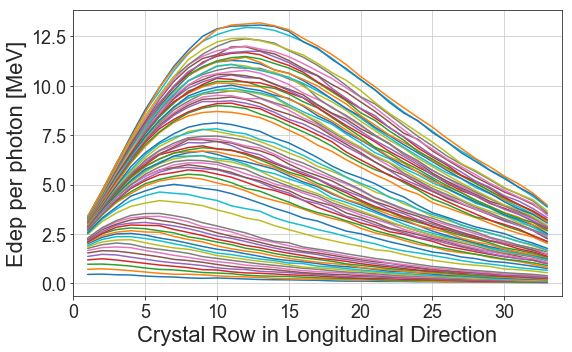

In [130]:
fig, ax = plt.subplots(figsize=(5*1.61,5))

for i in range(len(Case1_matfiles)):
    ax.plot(Case1_Edep_yaxis.T, Case1_Edep_array[i,:]/1e4, '-', label=Case1_Egamma_array[i]) # the factor 1e4 comes from the simulation which ran over 10k particles

    
#plt.title('Mean Electron Spectra for Cole and Poder')
ax.set_xlabel('Crystal Row in Longitudinal Direction', fontsize=axis_fontsize)
ax.set_ylabel('Edep per photon [MeV]', fontsize=axis_fontsize)
#leg = ax.legend(bbox_to_anchor=(1., 1.02, 1., .102), loc='upper right', ncol=2, mode="expand", borderaxespad=0.,fontsize=legends_fontsize, frameon=True)
#leg = leg.get_frame().set_linewidth(2.0)


ax.set_xlim((0, 34))
#x.set_ylim((0, 0.004))
ax.grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.tick_params(labelsize=ticks_fontsize)
ax.yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
#plt.savefig('Edep_CrystalRows.pdf')
plt.show()

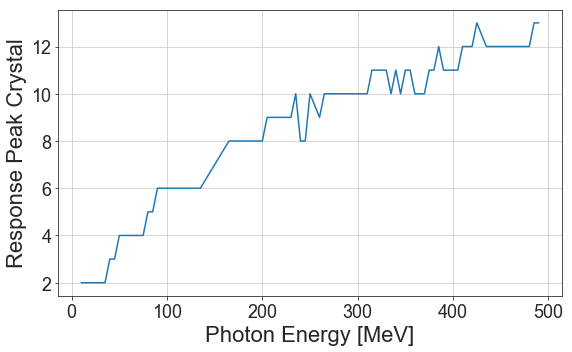

In [138]:
fig, ax = plt.subplots(figsize=(5*1.61,5))

ax.plot(Case1_Egamma_array[:,0], Case1_EdepMax[0], '-') # the factor 1e4 comes from the simulation which ran over 10k particles

    
#plt.title('Mean Electron Spectra for Cole and Poder')
ax.set_xlabel('Photon Energy [MeV]', fontsize=axis_fontsize)
ax.set_ylabel('Response Peak Crystal', fontsize=axis_fontsize)
#leg = ax.legend(bbox_to_anchor=(1., 1.02, 1., .102), loc='upper right', ncol=2, mode="expand", borderaxespad=0.,fontsize=legends_fontsize, frameon=True)
#leg = leg.get_frame().set_linewidth(2.0)


#ax.set_xlim((0, 500))
#x.set_ylim((0, 0.004))
ax.grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.tick_params(labelsize=ticks_fontsize)
ax.yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
#plt.savefig('Edep_CrystalRows.pdf')
plt.show()

## Case 2

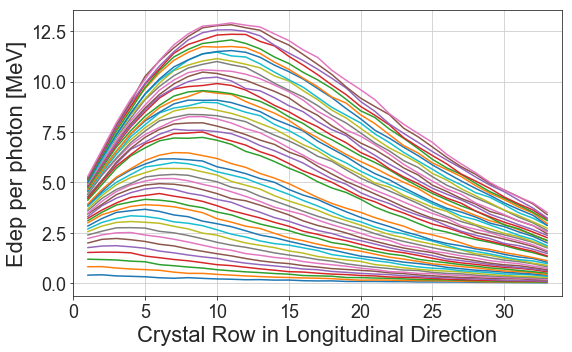

In [132]:
fig, ax = plt.subplots(figsize=(5*1.61,5))

for i in range(len(Case2_matfiles)):
    ax.plot(Case2_Edep_yaxis.T, Case2_Edep_array[i,:]/1e4, '-', label=Case2_Egamma_array[i]) # the factor 1e4 comes from the simulation which ran over 10k particles

    
#plt.title('Mean Electron Spectra for Cole and Poder')
ax.set_xlabel('Crystal Row in Longitudinal Direction', fontsize=axis_fontsize)
ax.set_ylabel('Edep per photon [MeV]', fontsize=axis_fontsize)
#leg = ax.legend(bbox_to_anchor=(1., 1.02, 1., .102), loc='upper right', ncol=2, mode="expand", borderaxespad=0.,fontsize=legends_fontsize, frameon=True)
#leg = leg.get_frame().set_linewidth(2.0)


ax.set_xlim((0, 34))
#x.set_ylim((0, 0.004))
ax.grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.tick_params(labelsize=ticks_fontsize)
ax.yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
#plt.savefig('Edep_CrystalRows.pdf')
plt.show()

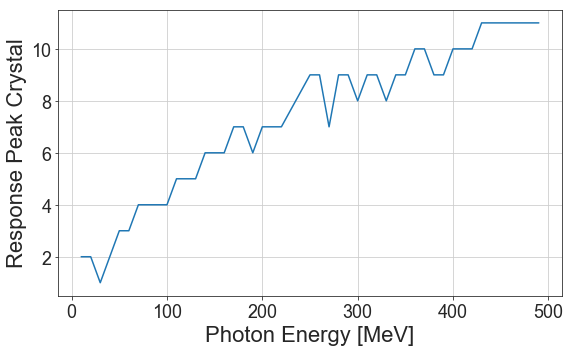

In [139]:
fig, ax = plt.subplots(figsize=(5*1.61,5))

ax.plot(Case2_Egamma_array[:,0], Case2_EdepMax[0], '-') # the factor 1e4 comes from the simulation which ran over 10k particles

    
#plt.title('Mean Electron Spectra for Cole and Poder')
ax.set_xlabel('Photon Energy [MeV]', fontsize=axis_fontsize)
ax.set_ylabel('Response Peak Crystal', fontsize=axis_fontsize)
#leg = ax.legend(bbox_to_anchor=(1., 1.02, 1., .102), loc='upper right', ncol=2, mode="expand", borderaxespad=0.,fontsize=legends_fontsize, frameon=True)
#leg = leg.get_frame().set_linewidth(2.0)


#ax.set_xlim((0, 500))
#x.set_ylim((0, 0.004))
ax.grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.tick_params(labelsize=ticks_fontsize)
ax.yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
#plt.savefig('Edep_CrystalRows.pdf')
plt.show()

## Case 3

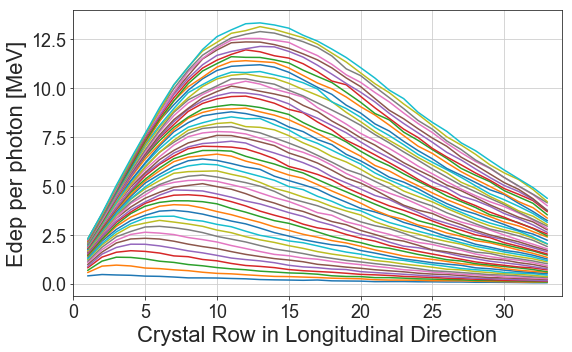

In [133]:
fig, ax = plt.subplots(figsize=(5*1.61,5))

for i in range(len(Case3_matfiles)):
    ax.plot(Case3_Edep_yaxis.T, Case3_Edep_array[i,:]/1e4, '-', label=Case3_Egamma_array[i]) # the factor 1e4 comes from the simulation which ran over 10k particles

    
#plt.title('Mean Electron Spectra for Cole and Poder')
ax.set_xlabel('Crystal Row in Longitudinal Direction', fontsize=axis_fontsize)
ax.set_ylabel('Edep per photon [MeV]', fontsize=axis_fontsize)
#leg = ax.legend(bbox_to_anchor=(1., 1.02, 1., .102), loc='upper right', ncol=2, mode="expand", borderaxespad=0.,fontsize=legends_fontsize, frameon=True)
#leg = leg.get_frame().set_linewidth(2.0)


ax.set_xlim((0, 34))
#x.set_ylim((0, 0.004))
ax.grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.tick_params(labelsize=ticks_fontsize)
ax.yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
#plt.savefig('Edep_CrystalRows.pdf')
plt.show()

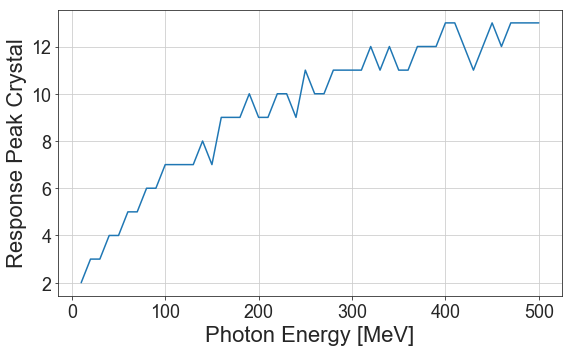

In [140]:
fig, ax = plt.subplots(figsize=(5*1.61,5))

ax.plot(Case3_Egamma_array[:,0], Case3_EdepMax[0], '-') # the factor 1e4 comes from the simulation which ran over 10k particles

    
#plt.title('Mean Electron Spectra for Cole and Poder')
ax.set_xlabel('Photon Energy [MeV]', fontsize=axis_fontsize)
ax.set_ylabel('Response Peak Crystal', fontsize=axis_fontsize)
#leg = ax.legend(bbox_to_anchor=(1., 1.02, 1., .102), loc='upper right', ncol=2, mode="expand", borderaxespad=0.,fontsize=legends_fontsize, frameon=True)
#leg = leg.get_frame().set_linewidth(2.0)


#ax.set_xlim((0, 500))
#x.set_ylim((0, 0.004))
ax.grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.tick_params(labelsize=ticks_fontsize)
ax.yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
#plt.savefig('Edep_CrystalRows.pdf')
plt.show()

## Comparison

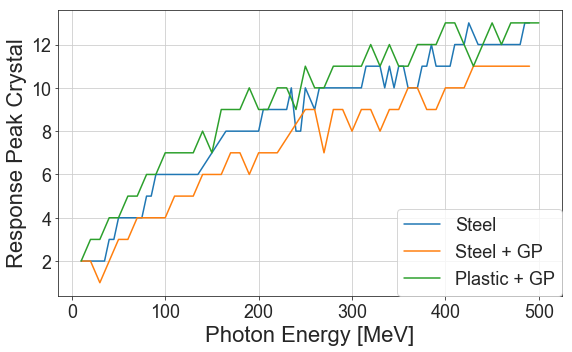

In [147]:
fig, ax = plt.subplots(figsize=(5*1.61,5))

ax.plot(Case1_Egamma_array[:,0], Case1_EdepMax[0], '-', label='Steel')
ax.plot(Case2_Egamma_array[:,0], Case2_EdepMax[0], '-', label='Steel + GP')
ax.plot(Case3_Egamma_array[:,0], Case3_EdepMax[0], '-', label='Plastic + GP') 
    
#plt.title('Mean Electron Spectra for Cole and Poder')
ax.set_xlabel('Photon Energy [MeV]', fontsize=axis_fontsize)
ax.set_ylabel('Response Peak Crystal', fontsize=axis_fontsize)
leg = ax.legend(loc='lower right', borderaxespad=0.,fontsize=legends_fontsize, frameon=True)
#leg = leg.get_frame().set_linewidth(2.0)


#ax.set_xlim((0, 500))
#x.set_ylim((0, 0.004))
ax.grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.tick_params(labelsize=ticks_fontsize)
ax.yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
plt.savefig('EdepMax_Cases.pdf')
plt.show()